### 导入实验所需模块

In [8]:
# 导入相关依赖库
import  os
import csv
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import mindspore as ms
import mindspore.dataset as ds
import mindspore.context as context
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV

from mindspore import nn, Tensor
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy, MAE, MSE
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend') 


RuntimeError: Unsupported device target Ascend. This process only supports one of the ['CPU']. Please check whether the Ascend environment is installed and configured correctly, and check whether current mindspore wheel package was built with "-e Ascend".

----------------------------------------------------
- C++ Call Stack: (For framework developers)
----------------------------------------------------
mindspore\core\utils\ms_context.cc:328 mindspore::MsContext::SetDeviceTargetFromInner


### 查看数据格式

In [9]:
# 加载数据集
with open('../data/auto-mpg.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
print(data[20:40]) # 打印部分数据 

[['25.0   4   110.0      87.00      2672.      17.5   70  2\t"peugeot 504"'], ['24.0   4   107.0      90.00      2430.      14.5   70  2\t"audi 100 ls"'], ['25.0   4   104.0      95.00      2375.      17.5   70  2\t"saab 99e"'], ['26.0   4   121.0      113.0      2234.      12.5   70  2\t"bmw 2002"'], ['21.0   6   199.0      90.00      2648.      15.0   70  1\t"amc gremlin"'], ['10.0   8   360.0      215.0      4615.      14.0   70  1\t"ford f250"'], ['10.0   8   307.0      200.0      4376.      15.0   70  1\t"chevy c20"'], ['11.0   8   318.0      210.0      4382.      13.5   70  1\t"dodge d200"'], ['9.0    8   304.0      193.0      4732.      18.5   70  1\t"hi 1200d"'], ['27.0   4   97.00      88.00      2130.      14.5   71  3\t"datsun pl510"'], ['28.0   4   140.0      90.00      2264.      15.5   71  1\t"chevrolet vega 2300"'], ['25.0   4   113.0      95.00      2228.      14.0   71  3\t"toyota corona"'], ['25.0   4   98.00      ?          2046.      19.0   71  1\t"ford pinto"'], ['

### 利用pandas模块读取数据

In [10]:
# 使用pandas读取数据
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
# 遇到？换成nan，忽略\t之后的内容，以空格作为分隔符。
raw_data = pd.read_csv('../data/auto-mpg.data', names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

data = raw_data.copy()

# 查看数据形状
data.shape

(398, 8)

### 数据预处理
对于数据集中的空值，我们要在建模前进行处理。此处空值的数据较少，我们直接进行删除。特征Origin代表着车辆的归属区域信息，此处总共分为三种，欧洲，美国，日本，我们需要对此特征进行one-hot编码。

此处MPG为Y值，其余的特征为X值。

In [11]:
# 对于数据集中的空值，我们要在建模前进行处理。此处空值的数据较少，我们直接进行删除。
# 清洗空数据
data = data.dropna()
data.tail()
# Pandas库提供了简单的数据集统计信息，我们可直接调用函数describe()进行查看。
# 查看训练数据集的结构
origin = data.pop('Origin')
data_labels = data.pop('MPG')
train_stats = data.describe()
train_stats = train_stats.transpose()
train_stats
# 归一化数据
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_data = norm(data)
# 将MPG放回归一化后的数据中
normed_data['MPG'] = data_labels
# 离散特征处理
# 特征Origin代表着车辆的归属区域信息，此处总共分为三种，欧洲，美国，日本，我们需要对此特征进行one-hot编码。
# 对origin属性进行one-hot编码
normed_data['USA'] = (origin == 1)*1.0
normed_data['Europe'] = (origin == 2)*1.0
normed_data['Japan'] = (origin == 3)*1.0

### 将数据分割为训练集和验证集

In [12]:
# 将数据集按照4：1划分成训练集和测试集
train_dataset = normed_data.sample(frac=0.8,random_state=0)
test_dataset = normed_data.drop(train_dataset.index)

# 模型训练需要区分特征值与目标值，也就是我们常说的X值与Y值，此处MPG为Y值，其余的特征为X值。
# 将目标值和特征分开
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

X_train, Y_train = np.array(train_dataset), np.array(train_labels)
X_test, Y_test = np.array(test_dataset), np.array(test_labels)

# 查看数据集尺寸
print('训练数据x尺寸：',X_train.shape)
print('训练数据y尺寸：',Y_train.shape)
print('测试数据x尺寸：',X_test.shape)
print('测试数据y尺寸：',Y_test.shape)
# 将数据集转换为Tensor格式
ds_xtrain= Tensor(X_train, ms.float32)
ds_ytrain= Tensor(Y_train, ms.int32)

ds_xtest=Tensor(X_test, ms.float32)
ds_ytest=Tensor(Y_test, ms.int32)

训练数据x尺寸： (314, 9)
训练数据y尺寸： (314,)
测试数据x尺寸： (78, 9)
测试数据y尺寸： (78,)


### 创建网络

In [13]:
# 定义网络
class Regression_car(nn.Cell):
    def __init__(self):
        super(Regression_car, self).__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.fc1 = nn.Dense(9,64, activation='relu')
        self.fc2 = nn.Dense(64,64, activation='relu')
        self.fc3 = nn.Dense(64,1)
        
        
    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

### 设定参数并训练模型

In [14]:
# 定义网络，损失函数，评估指标，优化器
network = Regression_car()
net_loss = nn.MSELoss()
net_opt = nn.RMSProp(network.trainable_params(), 0.001)

# 使用单步训练的方式来使结果中打印出MAE、MSE
# Cell是所有神经网络的基类。Cell可以是一个单一的神经网络单元，如conv2d、relu、batch_norm等，也可以是一个用于构建网络的单元的组合。
# WithLossCell意味着使用损耗函数对网络进行包裹。此单元接受数据和标签作为输入，并返回计算的损耗。
with_loss=nn.WithLossCell(network, net_loss) 
train_step = nn.TrainOneStepCell(with_loss, net_opt).set_train()
# WithEvalCell返回loss、输出和标签的单元，用于评估。此单元接受网络和loss函数作为参数，并计算模型的loss。它返回loss、输出和标签来计算度量。
evalcell=nn.WithEvalCell(network,net_loss)
# 创建指标类
mae = nn.MAE()
mse = nn.MSE()
val_mae = nn.MAE()
val_mse = nn.MSE()
    
# 创建一个空的Dataframe
result =pd.DataFrame(columns=('_epoch','_loss','_mae','_mse','val_mae','val_mse'))
print("============== Starting Training ==============")
for epoch in range(300):
    # 利用train_step去接收训练集，更新网络参数得到loss值
    loss = train_step(ds_xtrain,ds_ytrain)
    # 利用evalcell接收训练集获取训练过程的输出用于计算mae和mse，接收测试集获取测试集输出
    _, outputs, label = evalcell(ds_xtrain,ds_ytrain)
    _, val_outputs, val_label = evalcell(ds_xtest,ds_ytest)
    
    # 每次循环都更新MAE、MSE等的值。
    mae.clear()
    mae.update(outputs, label)
    mse.clear()
    mse.update(outputs, label)
    val_mae.clear()
    val_mae.update(val_outputs, val_label)
    val_mse.clear()
    val_mse.update(val_outputs, val_label)
    
    Mae = mae.eval()
    Mse = mse.eval()
    Val_Mae = val_mae.eval()
    Val_Mse = val_mse.eval()
    
    nd_loss = loss.asnumpy()
    fl_loss = float(nd_loss)/24.0

    # 将计算结果逐行插入result,注意变量要用[]括起来,同时ignore_index=True，否则会报错，ValueError: If using all scalar values, you must pass an index
    result=result.append(pd.DataFrame({'_epoch':[epoch],'_loss':fl_loss,'_mae':Mae,'_mse':Mse,
                                       'val_mae':Val_Mae,'val_mse':Val_Mse}),ignore_index=True)

    if epoch%10==0:
        print('epoch:{0},loss:{1},mae:{2},mse:{3},val_mae:{4},val_mse:{5}'.format(epoch,fl_loss,Mae,Mse,
                                                                                               Val_Mae,Val_Mse))
        print("*" * 110)
print(result)

============== Starting Training ==============


AttributeError: 'DataFrame' object has no attribute 'append'

### 查看模型训练状态

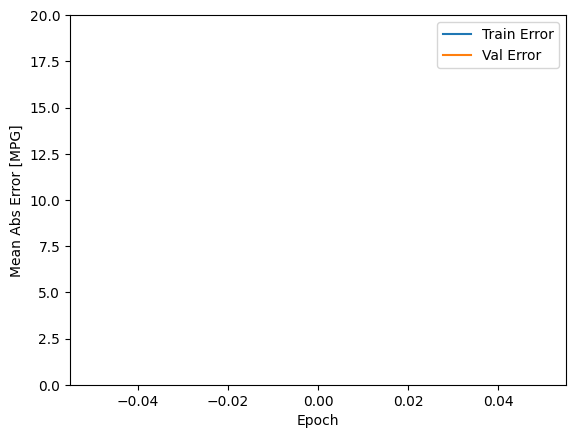

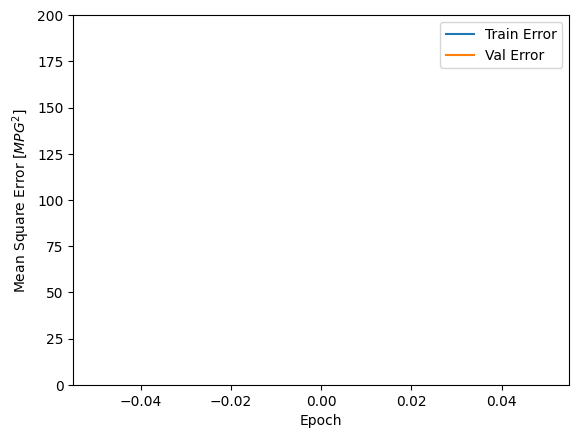

In [15]:
# 绘制模型损失函数图
def plot_history(result):

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(result['_epoch'], result['_mae'],
           label='Train Error')
    plt.plot(result['_epoch'], result['val_mae'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(result['_epoch'], result['_mse'],
           label='Train Error')
    plt.plot(result['_epoch'], result['val_mse'],
           label = 'Val Error')
    plt.ylim([0,200])
    plt.legend()
    plt.show()


plot_history(result)